🔼 Por favor, selecione uma imagem para análise (ex: imagem_teste.jpg)


Saving gato-e-cachorro-juntos-750x410.png to gato-e-cachorro-juntos-750x410 (5).png

image 1/1 /content/gato-e-cachorro-juntos-750x410 (5).png: 352x640 3 cats, 2 dogs, 1415.7ms
Speed: 2.6ms preprocess, 1415.7ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


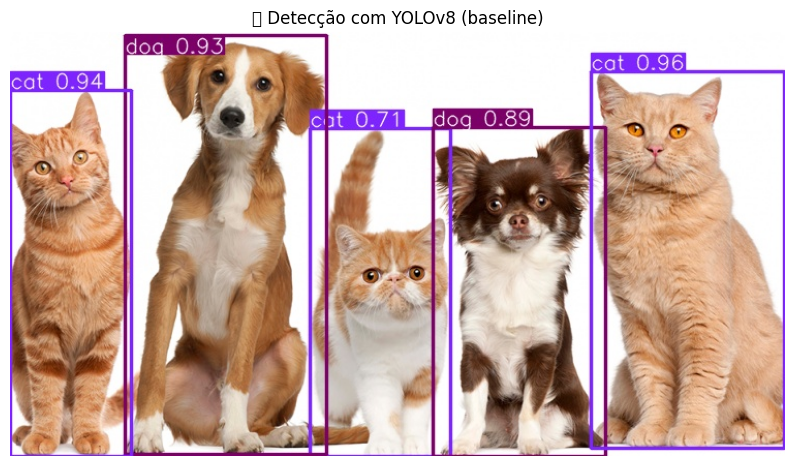

In [6]:
# Bloco 1 - Detecção com YOLOv8
# --------------------------------------
# Instalar YOLOv8 (Ultralytics)
!pip install -q ultralytics

# Importações
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import os
from google.colab import files

# Solicita upload da imagem
print("🔼 Por favor, selecione uma imagem para análise (ex: imagem_teste.jpg)")
uploaded = files.upload()

# Pega o caminho da imagem enviada
image_path = list(uploaded.keys())[0]

# Verifica se a imagem foi recebida corretamente
assert os.path.exists(image_path), f"Imagem não encontrada: {image_path}"

# Carrega o modelo YOLOv8 pré-treinado
model = YOLO('yolov8l.pt')  # 'n' = nano (mais rápido e leve para testes iniciais)

# Executa a detecção
results = model(image_path)

# Salva a imagem com as detecções
results[0].save(filename='resultado_yolo.jpg')

# Exibe a imagem com caixas e rótulos
img_result = Image.open('resultado_yolo.jpg')
plt.figure(figsize=(10, 8))
plt.imshow(img_result)
plt.axis('off')
plt.title('📦 Detecção com YOLOv8 (baseline)')
plt.show()

GPU disponível: []
Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 414s 690ms/step - accuracy: 0.9329 - loss: 0.1611 - val_accuracy: 0.9791 - val_loss: 0.0616
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 363s 624ms/step - accuracy: 0.9762 - loss: 0.0648 - val_accuracy: 0.9804 - val_loss: 0.0575
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 372s 639ms/step - accuracy: 0.9806 - loss: 0.0562 - val_accuracy: 0.9807 - val_loss: 0.0560


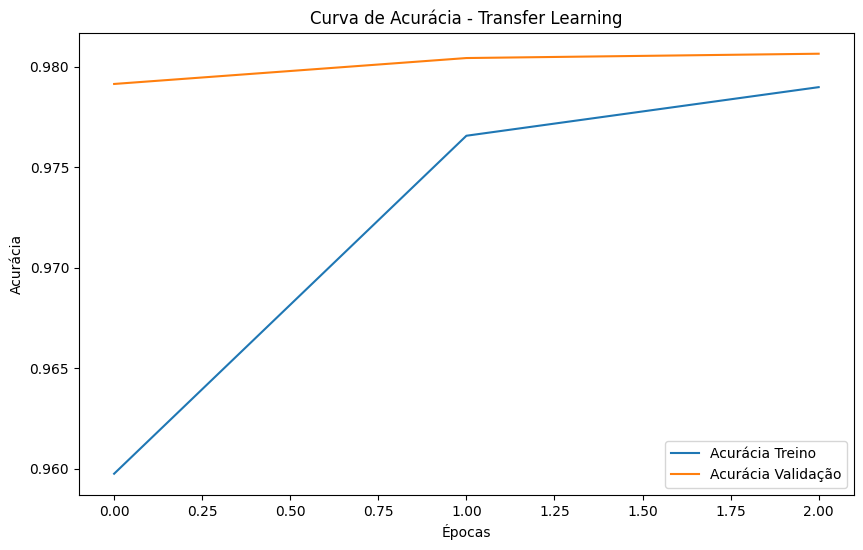

In [7]:
# Bloco 2 - Transfer Learning com MobileNetV2
# --------------------------------------------
# Importações específicas de deep learning
!pip install -q tensorflow tensorflow_datasets

# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Verificar GPU (opcional)
print("GPU disponível:", tf.config.list_physical_devices('GPU'))



# Carregar o dataset de gatos vs cachorros
(ds_train, ds_val), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Pré-processamento: redimensiona e normaliza as imagens
IMG_SIZE = (160, 160)

def format_img(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.map(format_img, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(format_img, num_parallel_calls=AUTOTUNE)

ds_train = ds_train.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Carrega o modelo base pré-treinado no ImageNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False # Congela a base


# Adiciona camadas finais para classificação binária
model_transfer = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compila o modelo
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=['accuracy'])

# Treina o modelo
epochs = 3
history = model_transfer.fit(ds_train,
                              validation_data=ds_val,
                              epochs=epochs)

# Plota a curva de aprendizado
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(acc, label='Acurácia Treino')
plt.plot(val_acc, label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.title('Curva de Acurácia - Transfer Learning')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


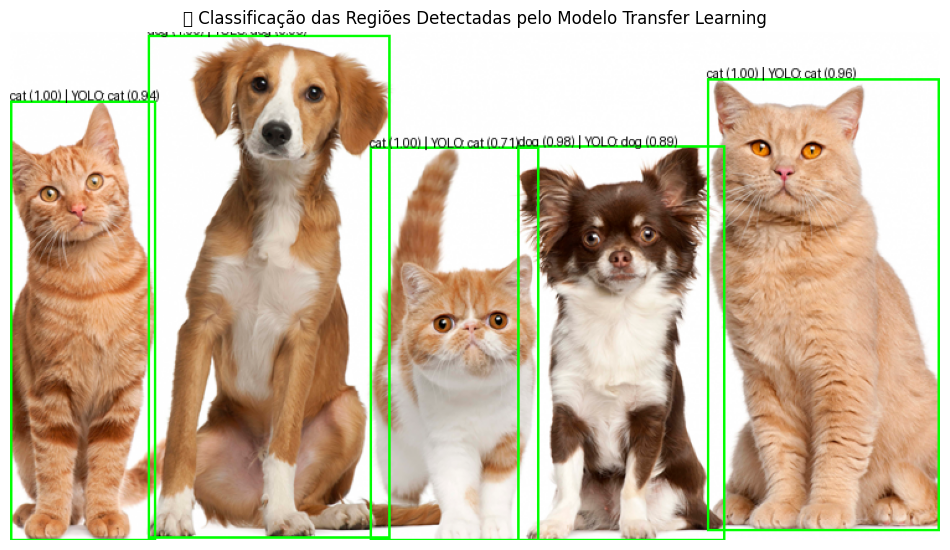

In [8]:
from PIL import ImageDraw
import cv2

# Recarrega a imagem original
original_img = Image.open(image_path).convert("RGB")
img_width, img_height = original_img.size

# Faz a detecção novamente (ou reutiliza o results[0])
detections = results[0].boxes

# Faz uma cópia da imagem para desenhar resultados
img_annotated = original_img.copy()
draw = ImageDraw.Draw(img_annotated)

# Loop sobre cada detecção
for i, box in enumerate(detections):
    # Coordenadas da caixa
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    conf_yolo = box.conf[0].item()
    class_yolo = int(box.cls[0].item())
    label_yolo = results[0].names[class_yolo]

    # Recorte da região detectada
    cropped = original_img.crop((x1, y1, x2, y2))

    # Redimensiona e normaliza como o modelo espera
    cropped_resized = cropped.resize(IMG_SIZE)
    img_array = np.array(cropped_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # adiciona batch

    # Previsão com seu modelo transfer
    pred = model_transfer.predict(img_array)[0][0]
    label_transfer = "dog" if pred > 0.5 else "cat"
    conf_transfer = pred if pred > 0.5 else 1 - pred

    # Desenha a caixa com as duas predições
    display_label = f"{label_transfer} ({conf_transfer:.2f}) | YOLO: {label_yolo} ({conf_yolo:.2f})"
    draw.rectangle([x1, y1, x2, y2], outline="lime", width=2)
    draw.text((x1, y1 - 10), display_label, fill="black")

# Exibe a imagem com anotações duplas (YOLO e classificador)
plt.figure(figsize=(12, 8))
plt.imshow(img_annotated)
plt.axis('off')
plt.title("📷 Classificação das Regiões Detectadas pelo Modelo Transfer Learning")
plt.show()


Epoch 1/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8546 - loss: 0.3537 - val_accuracy: 0.9757 - val_loss: 0.0714
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9533 - loss: 0.1181 - val_accuracy: 0.9787 - val_loss: 0.0634
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.9721 - loss: 0.0752 - val_accuracy: 0.9809 - val_loss: 0.0549
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.9847 - loss: 0.0540 - val_accuracy: 0.9830 - val_loss: 0.0464
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9911 - loss: 0.0370 - val_accuracy: 0.9847 - val_loss: 0.0390


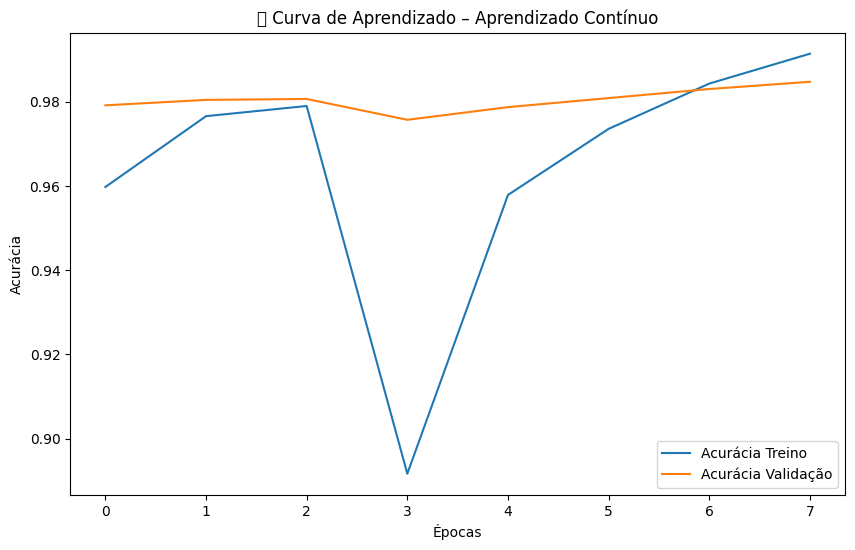

In [9]:
# Bloco 3 – Fine-Tuning com mais dados (aprendizado contínuo)

# Descongela parte do modelo base
base_model.trainable = True

# Define quantas camadas queremos ajustar (a partir da camada 100)
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compila novamente com taxa de aprendizado mais baixa
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Define novas épocas de treinamento
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

# Treina com os dados de validação agora como treino
history_finetune = model_transfer.fit(ds_val,
                                      validation_data=ds_val,
                                      epochs=fine_tune_epochs)

# Junta histórico antigo + novo para visualização contínua
acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']

# Plota curva de aprendizado completa
plt.figure(figsize=(10, 6))
plt.plot(range(total_epochs), acc, label='Acurácia Treino')
plt.plot(range(total_epochs), val_acc, label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.title('📈 Curva de Aprendizado – Aprendizado Contínuo')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


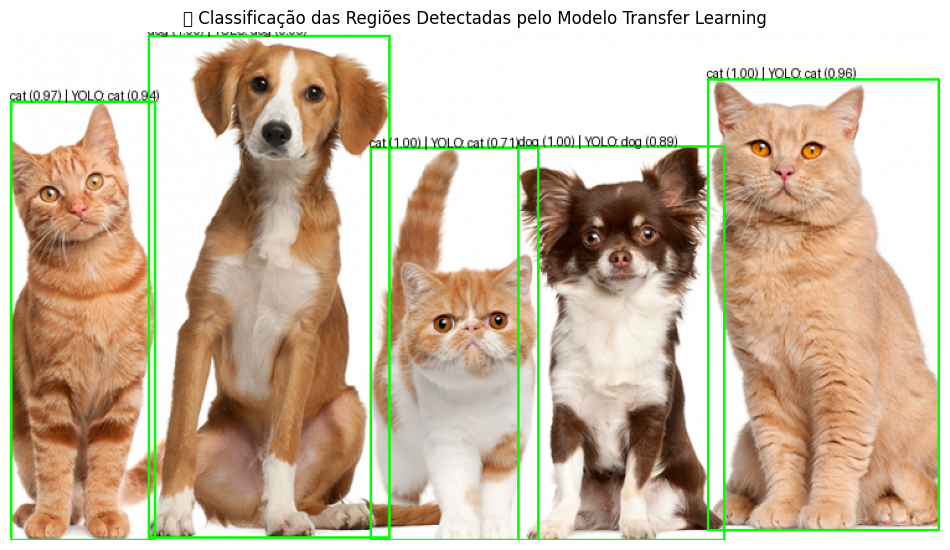

In [10]:
from PIL import ImageDraw
import cv2

# Recarrega a imagem original
original_img = Image.open(image_path).convert("RGB")
img_width, img_height = original_img.size

# Faz a detecção novamente (ou reutiliza o results[0])
detections = results[0].boxes

# Faz uma cópia da imagem para desenhar resultados
img_annotated = original_img.copy()
draw = ImageDraw.Draw(img_annotated)

# Loop sobre cada detecção
for i, box in enumerate(detections):
    # Coordenadas da caixa
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    conf_yolo = box.conf[0].item()
    class_yolo = int(box.cls[0].item())
    label_yolo = results[0].names[class_yolo]

    # Recorte da região detectada
    cropped = original_img.crop((x1, y1, x2, y2))

    # Redimensiona e normaliza como o modelo espera
    cropped_resized = cropped.resize(IMG_SIZE)
    img_array = np.array(cropped_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # adiciona batch

    # Previsão com seu modelo transfer
    pred = model_transfer.predict(img_array)[0][0]
    label_transfer = "dog" if pred > 0.5 else "cat"
    conf_transfer = pred if pred > 0.5 else 1 - pred

    # Desenha a caixa com as duas predições
    display_label = f"{label_transfer} ({conf_transfer:.2f}) | YOLO: {label_yolo} ({conf_yolo:.2f})"
    draw.rectangle([x1, y1, x2, y2], outline="lime", width=2)
    draw.text((x1, y1 - 10), display_label, fill="black")

# Exibe a imagem com anotações duplas (YOLO e classificador)
plt.figure(figsize=(12, 8))
plt.imshow(img_annotated)
plt.axis('off')
plt.title("📷 Classificação das Regiões Detectadas pelo Modelo Transfer Learning")
plt.show()